In [19]:
# All import goes here

import os

import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.layers import Dense, Embedding, Flatten
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [6]:
# glove embs link : https://nlp.stanford.edu/projects/glove/
# imdb data link : http://mng.bz/0tIo

In [7]:
'''
This block of code goes through the imdb dataset 
saves all the review paragraphs in a variable text 
and the corresponding label in labels variable
'''

imdb_dir = '/home/trinanjan/Desktop/aclImdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [8]:
maxlen = 100  # Cuts off reviews after 100 words
training_samples = 8000  # Trains on 8000 samples
validation_samples = 10000  # Validates on 10,000 samples
max_words = 10000  # Considers only the top 10,000 words in the dataset
tokenizer = Tokenizer(num_words=max_words)
# TODO whats the num_word attribute for as word_index.items() lenght is not same as num_words

# using keras inbuilt tokenizer
'''
fit_on_texts Updates internal vocabulary based on a list of texts.
This method creates the vocabulary index based on word frequency. 
So if you give it something like, "The cat sat on the mat." 
It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 
it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. 
So lower integer means more frequent word (often the first few are stop words because they appear a lot).
'''
tokenizer.fit_on_texts(texts)

# texts_to_sequences Transforms each text in texts to a sequence of integers
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [9]:
# so sequences that are shorter than others should be padded with zeros, and sequences
# that are longer should be truncated
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [10]:
'''
Splits the data into a training set and a
validation set, but first shuffles the data,
because samples are ordered (all negative first, 
then all positive)
'''
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [11]:
'''
good read glove : https://medium.com/@jonathan_hui/nlp-word-embedding-glove-5e7f523999f6
glove is pretained word-vectors, glove is trained on huge data (dependng on the data trained we use different models)
Using glove pretained weights we will set mature weights in our embedding layer

Instead of learning word embeddings jointly with the problem you want to solve,
you can load embedding vectors from a precomputed embedding space that you
know is highly structured and exhibits useful properties—that captures generic
aspects of language structure
'''

glove_dir = '/home/trinanjan/Desktop/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
'''
Next, we’ll build an embedding matrix that we can load into an Embedding layer. It
must be a matrix of shape (max_words, embedding_dim) , where each entry i contains
the embedding_dim -dimensional vector for the word of index i in the reference word
index (built during tokenization). Note that index 0 isn’t supposed to stand for any
word or token—it’s a placeholder.
'''
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [16]:
# model architecture to train
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [17]:
'''
The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is
the word vector meant to be associated with index i. Simple enough. Let's Load the GloVe
matrix we prepared into the Embedding layer, the first layer in the model.
'''
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [18]:
# compile and train the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 10000 samples
Epoch 1/20
8000/8000 [==============================] - 2s 296us/step - loss: 0.6939 - acc: 0.5926 - val_loss: 0.6047 - val_acc: 0.6833
Epoch 2/20
8000/8000 [==============================] - 2s 280us/step - loss: 0.5585 - acc: 0.7183 - val_loss: 0.6374 - val_acc: 0.6533
Epoch 3/20
8000/8000 [==============================] - 2s 285us/step - loss: 0.4776 - acc: 0.7721 - val_loss: 0.5864 - val_acc: 0.6978
Epoch 4/20
8000/8000 [==============================] - 2s 253us/step - loss: 0.4077 - acc: 0.8193 - val_loss: 0.6343 - val_acc: 0.6868
Epoch 5/20
8000/8000 [==============================] - 2s 282us/step - loss: 0.3467 - acc: 0.8518 - val_loss: 0.6195 - val_acc: 0.7005
Epoch 6/20
8000/8000 [==============================] - 2s 267us/step - loss: 0.2945 - acc: 0.8767 - val_loss: 0.7216 - val_acc: 0.6850
Epoch 7/20
8000/8000 [===============

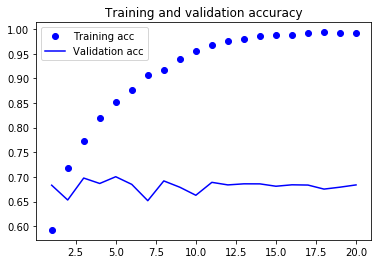

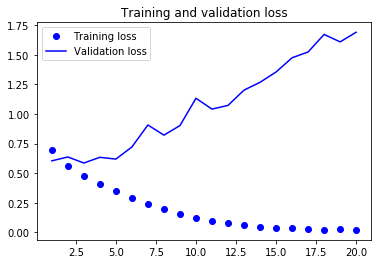

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()